<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3, ResNet50, ResNet50V2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [92]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 32


# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        "archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        # shuffle=False,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

# Load the training and validation datasets
train_ds_raw = build_trainset("training")
val_ds_raw = build_trainset("validation")

class_names = train_ds_raw.class_names
print(class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [93]:
# Preprocessing of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(Rescaling(1./255))
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

def preprocess(image, label):
    image = preprocessing_model(image)
    return image, label

train_ds = train_ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Text(0.5, 1.0, 'Preprocessed Image')

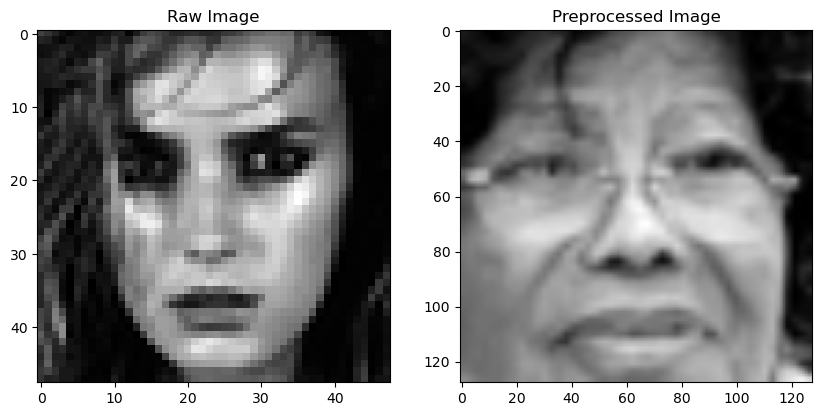

In [94]:
#show difference between original and preprocessed image

# Extract one batch of data from the datasets
raw_batch = train_ds_raw.take(1)
preproc_batch = train_ds.take(1)

# Extract images from the batches (assuming the batches contain (image, label) tuples)
for raw_image, _ in raw_batch:
    image_raw = raw_image.numpy()
    break

for prep_image, _ in preproc_batch:
    image_prep = prep_image.numpy()
    break

# If the preprocessed image is in RGB, convert it back to grayscale for comparison
image_raw = image_raw[0, :, :, 0]
image_prep = image_prep[0, :, :, 0]

fig , ax = plt.subplots(1,2 , figsize=(10,5))
ax[0].imshow(image_raw, cmap='gray')
ax[1].imshow(image_prep, cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Preprocessed Image')


In [95]:
# adding augmentation to the dataset 

augmentation = False

if augmentation:
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
    ])

    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


In [96]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

In [97]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

# #Use ResNet50 as the base model
base_model = ResNet50(
    input_shape=(model_pixels, model_pixels, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)



# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze all layers except the top layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add layers on top of the base model
model = Sequential([base_model,
                    # GlobalAveragePooling2D(),
                    # Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(len(class_names),  activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
                    ])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,950,087 (98.99 MB)

 Trainable params: 5,778,951 (22.04 MB)

 Non-trainable params: 20,171,136 (76.95 MB)

In [98]:

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("train_size: ", train_size)

steps_per_epoch:  358
validation_steps:  179
train_size:  22968


In [99]:
# Train the model

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=1e-6)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

# with tf.device('/device:GPU:0'):
hist = model.fit(train_ds,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_ds,
                  validation_steps=validation_steps,
                  callbacks=[reduce_lr]#, early_stopping, checkpoint, tensorboard]
                  ).history
  



Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 270s 742ms/step - accuracy: 0.2422 - loss: 1.8425 - val_accuracy: 0.1192 - val_loss: 2.2624 - learning_rate: 0.0050
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 265s 740ms/step - accuracy: 0.2971 - loss: 1.7325 - val_accuracy: 0.3170 - val_loss: 1.7007 - learning_rate: 0.0050
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 261s 729ms/step - accuracy: 0.3211 - loss: 1.6851 - val_accuracy: 0.2976 - val_loss: 1.7275 - learning_rate: 0.0050
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 262s 731ms/step - accuracy: 0.3354 - loss: 1.6610 - val_accuracy: 0.3508 - val_loss: 1.6425 - learning_rate: 0.0050
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 269s 753ms/step - accuracy: 0.3541 - loss: 1.6433 - val_accuracy: 0.3356 - val_loss: 1.6739 - learning_rate: 0.0050
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.3610 - loss: 1.6193
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
358/358 ━━━━━━━━━━━━━━━━━━━━ 272s 759ms/step - accuracy:

#### Load model

In [57]:

#load model 
# model = tf.keras.models.load_model("ResNet50_v3.keras")

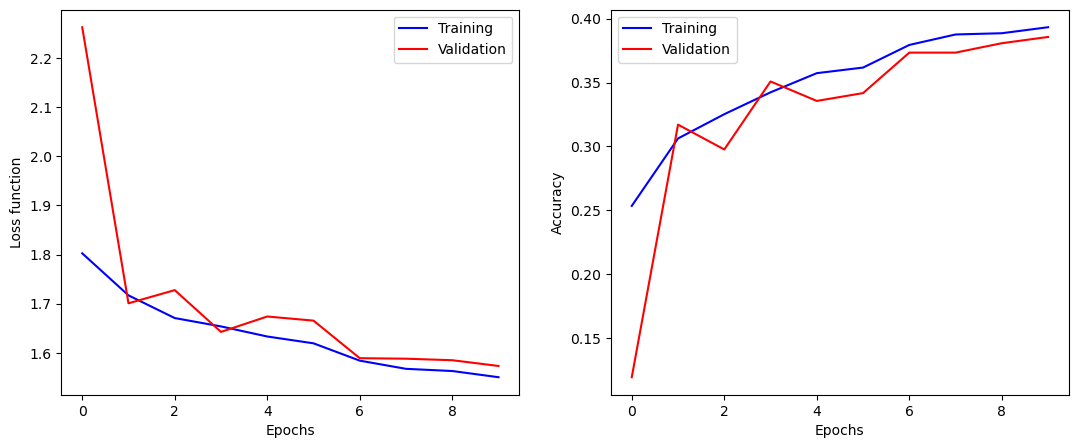

In [100]:

fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].plot(hist["loss"], label="Training", c='b')
ax[0].plot(hist["val_loss"], label="Validation", c='r')
ax[0].set_ylabel("Loss function")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(hist["accuracy"], label="Training", c='b')
ax[1].plot(hist["val_accuracy"], label="Validation", c='r')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()


In [34]:
def build_testset():
    return image_dataset_from_directory(
                        f"archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [103]:
# Build test set and apply the preprocessing model to the test dataset
test_ds = build_testset()
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)


cm = confusion_matrix(y_true, y_pred)


# Calculate accuracy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

label_diff = y_pred - y_true
correct_predictions = len(y_true) - np.count_nonzero(label_diff)
accuracy = correct_predictions / len(y_true)
print(accuracy)


# Find out accuracy of each class
class_acc = np.zeros(len(cm))
for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])
print(class_acc)

Found 7178 files belonging to 7 classes.
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 218s 30ms/step
0.21008637503482863
[0.00313152 0.         0.0859375  0.35118377 0.32360097 0.24218123
 0.11191336]


2024-06-09 12:05:45.368659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/tmp/ipykernel_23460/264775818.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(class_names, rotation=45)


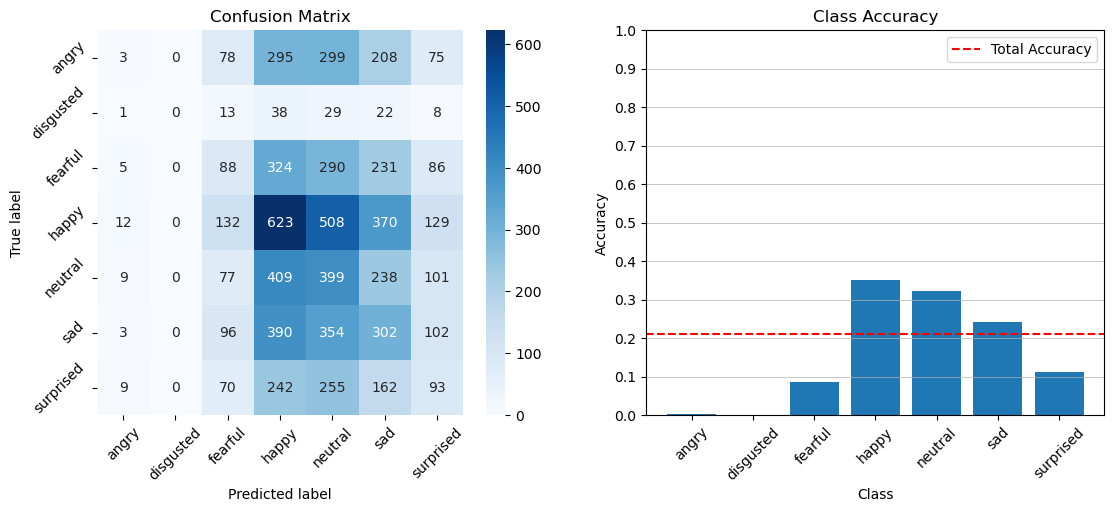

In [104]:
fig , ax = plt.subplots(1,2 , figsize=(13,5))
#cm heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Confusion Matrix')
ax[0].set_xticklabels(class_names, rotation=45)
ax[0].set_yticklabels(class_names, rotation=45)

#class accuracy
ax[1].bar(class_names, class_acc)
#add total accuracy as horizontal line
ax[1].axhline(accuracy, color='red', linestyle='--', label='Total Accuracy')
ax[1].legend()
ax[1].set_title('Class Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(class_names, rotation=45)
ax[1].set_ylim([0, 1])
#horizontal grid lines every 10%
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax[1].yaxis.grid(True, which='major', linewidth=0.5)
plt.show()



In [105]:
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 206s 29ms/step - accuracy: 0.3837 - loss: 1.5655
Test loss: 1.5536997318267822
Test accuracy: 0.3956533968448639


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


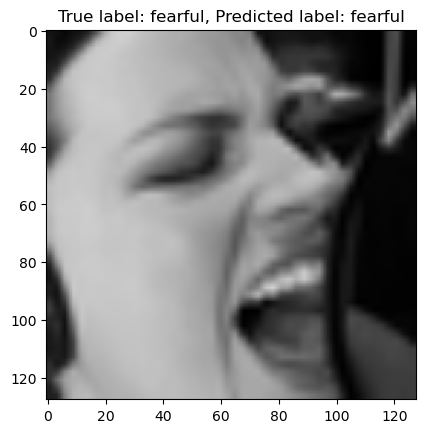

2024-06-08 14:16:34.277336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [54]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0])
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()

In [101]:
model.save("ResNet50_v5.keras")